In [2]:
from google.colab import files
file = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [4]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 56.2MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.9MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 83.8MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("train.csv.zip","r") as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("test.csv.zip","r") as zip_ref:
    zip_ref.extractall()

In [28]:
import numpy as np
train = np.loadtxt('train.csv', skiprows=1, delimiter=',')
test = np.loadtxt('test.csv', skiprows=1, delimiter=',')

In [29]:
x_train = train[:, 1:]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train /= 255.0
y_train = train[:, 0]

In [30]:
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train)

In [31]:
from sklearn.model_selection import train_test_split
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [32]:
X_train.shape

(37800, 28, 28, 1)

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten 

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
model_cnn_save_path = 'cnn.h5'
сheckpoint = ModelCheckpoint(model_cnn_save_path, 
                              monitor='val_accuracy', 
                              save_best_only=True,
                              verbose=1)

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [38]:
X_train.shape[0]

37800

In [39]:
batch_size=96

In [40]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), 
                    epochs=30,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=1,
                    callbacks=[сheckpoint, learning_rate_reduction])

Epoch 1/30
393/393 [==============================] - 264s 669ms/step - loss: 0.4187 - accuracy: 0.8639 - val_loss: 0.0581 - val_accuracy: 0.9807

Epoch 00001: val_accuracy improved from -inf to 0.98071, saving model to cnn.h5
Epoch 2/30
393/393 [==============================] - 261s 663ms/step - loss: 0.1398 - accuracy: 0.9584 - val_loss: 0.0490 - val_accuracy: 0.9855

Epoch 00002: val_accuracy improved from 0.98071 to 0.98548, saving model to cnn.h5
Epoch 3/30
393/393 [==============================] - 261s 664ms/step - loss: 0.1015 - accuracy: 0.9700 - val_loss: 0.0284 - val_accuracy: 0.9914

Epoch 00003: val_accuracy improved from 0.98548 to 0.99143, saving model to cnn.h5
Epoch 4/30
393/393 [==============================] - 259s 660ms/step - loss: 0.0831 - accuracy: 0.9753 - val_loss: 0.0344 - val_accuracy: 0.9905

Epoch 00004: val_accuracy did not improve from 0.99143
Epoch 5/30
393/393 [==============================] - 260s 661ms/step - loss: 0.0780 - accuracy: 0.9772 - val_l

In [41]:
model.load_weights(model_cnn_save_path)

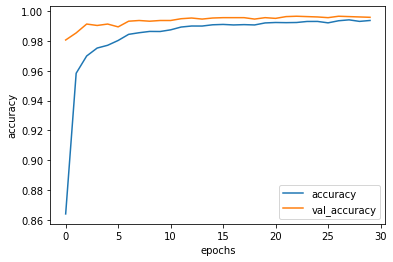

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], 
         label='accuracy')
plt.plot(history.history['val_accuracy'], 
         label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [43]:
test = np.loadtxt('test.csv', skiprows=1, delimiter=",")
x_test = test.reshape(test.shape[0], 28, 28, 1)
x_test = x_test / 255.0

In [44]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

In [45]:
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

In [46]:
np.savetxt('submission.csv', out, header='ImageId,Label', 
            comments='', fmt='%d,%d')

In [47]:
!kaggle competitions submit -c digit-recognizer -m 'decision' -f submission.csv

100% 208k/208k [00:03<00:00, 57.9kB/s]
Successfully submitted to Digit Recognizer